# IMPORT LIBRARIES

In [1]:
import pandas as pd

import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score

import seaborn as sns

import matplotlib.pyplot as plt

import os

# CONFIGURATION

In [2]:
sOutputSymbol = "BTCUSD"

sModelType = 'MLP'
iBatchSize = 90
iNrOfHiddenNeurons = 197
iBackwardTimeWindow = 3
iForwardTimeWindow = 3

In [3]:
sModelName = os.path.join(sOutputSymbol , sModelType + '_' +str(iBackwardTimeWindow) + '_'+ str(iForwardTimeWindow) +  '_'+ str(iBatchSize) +  '_'+  str(iNrOfHiddenNeurons) )

In [4]:
dfOhlc = pd.read_csv('Static Data\dfOhlc.csv', index_col = 0)
dfActual = pd.read_csv(sModelName+'\dfActual.csv',header=[0, 1], index_col=0)
dfPrediction = pd.read_csv(sModelName+'\dfPrediction.csv',header=[0, 1], index_col=0)

In [5]:
iComparisionTimeStep = 0

# CONVERT [return] TO [close]

In [6]:
def dfGetClosePricesFromReturns(dfToConvert):
    dfClose = dfToConvert.copy() 
    
    for sCol in dfClose.columns:
        iTimeStep = int(sCol[0])
        sSymbolFeature = sCol[1]
        aSymbolFeature = sSymbolFeature.split(':')
        sSymbol = aSymbolFeature[0]
        sFeature = aSymbolFeature[1]
        
        dfReturns = dfToConvert.loc[:,sCol ]

        if iTimeStep == 0:
            dfOpenPrices = dfOhlc.loc[dfClose.index, sSymbol+':open']
        else:
            dfOpenPrices =  dfClose.loc[:, (str(iTimeStep-1), sSymbolFeature)]
        
        dfClose.loc[:, sCol] = (dfOpenPrices * dfReturns) + dfOpenPrices
    
    dfClose.rename(columns = {sOutputSymbol+':return' :sOutputSymbol+':close'}, level=1, inplace = True)
    return dfClose

In [7]:
dfActualClose = dfGetClosePricesFromReturns(dfActual)
dfPredictionClose = dfGetClosePricesFromReturns(dfPrediction)

# RESULTS 

## Regression Metrics

In [8]:
y_pred = dfPredictionClose.iloc[:, iComparisionTimeStep]
y_true = dfActualClose.iloc[:, iComparisionTimeStep]
aMetrics = [
        ('mean absolute error', mean_absolute_error(y_true, y_pred)),
        ('mean squared error', mean_squared_error(y_true, y_pred)),
        ('max error', max_error(y_true, y_pred)),
        ('r2 score', r2_score(y_true, y_pred))
    ]

print('Metrics for regression:')
for metric_name, metric_value in aMetrics:
    print(f'{metric_name:>25s}: {metric_value: >20.3f}')

Metrics for regression:
      mean absolute error:              211.369
       mean squared error:            81474.028
                max error:             1312.705
                 r2 score:                0.989


## Scatter Plot

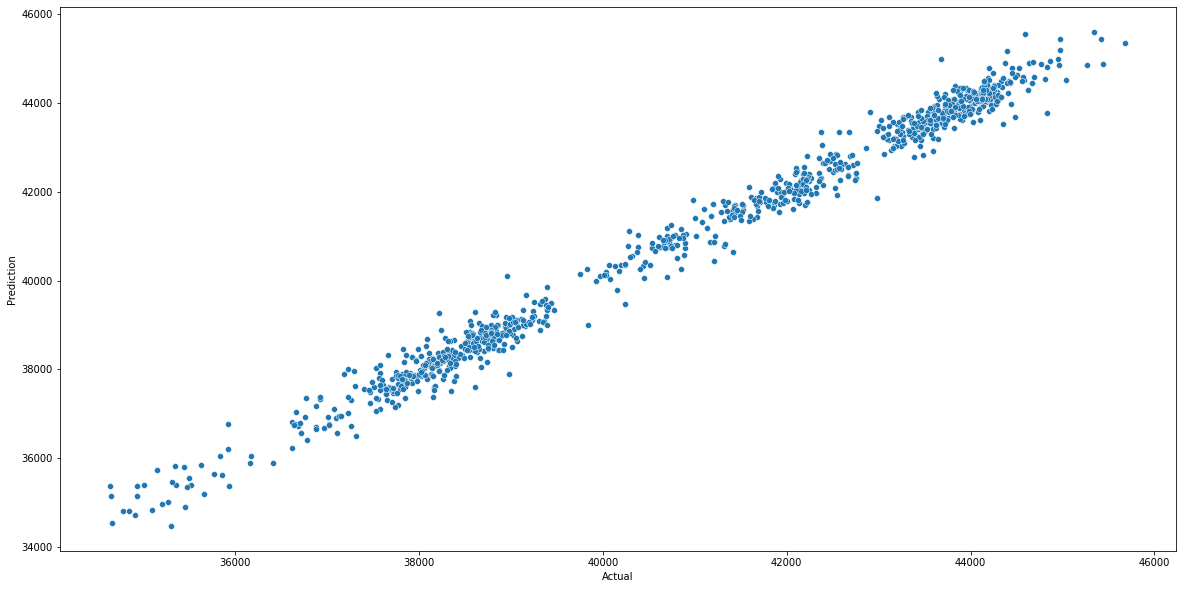

In [9]:
dfTestComparision = pd.DataFrame(dfPredictionClose.iloc[:,iComparisionTimeStep])
dfTestComparision = dfTestComparision.join(dfActualClose.iloc[:,iComparisionTimeStep], how = "inner", lsuffix="prediction")
dfTestComparision.columns = ["Prediction", "Actual"]

plt.figure(figsize = (20,10))
oFig = sns.scatterplot(data = dfTestComparision, x = "Actual", y ="Prediction")
oFig.get_figure().savefig(sModelName + '\closing price scatter.png')

## Multi Step Comparision

C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


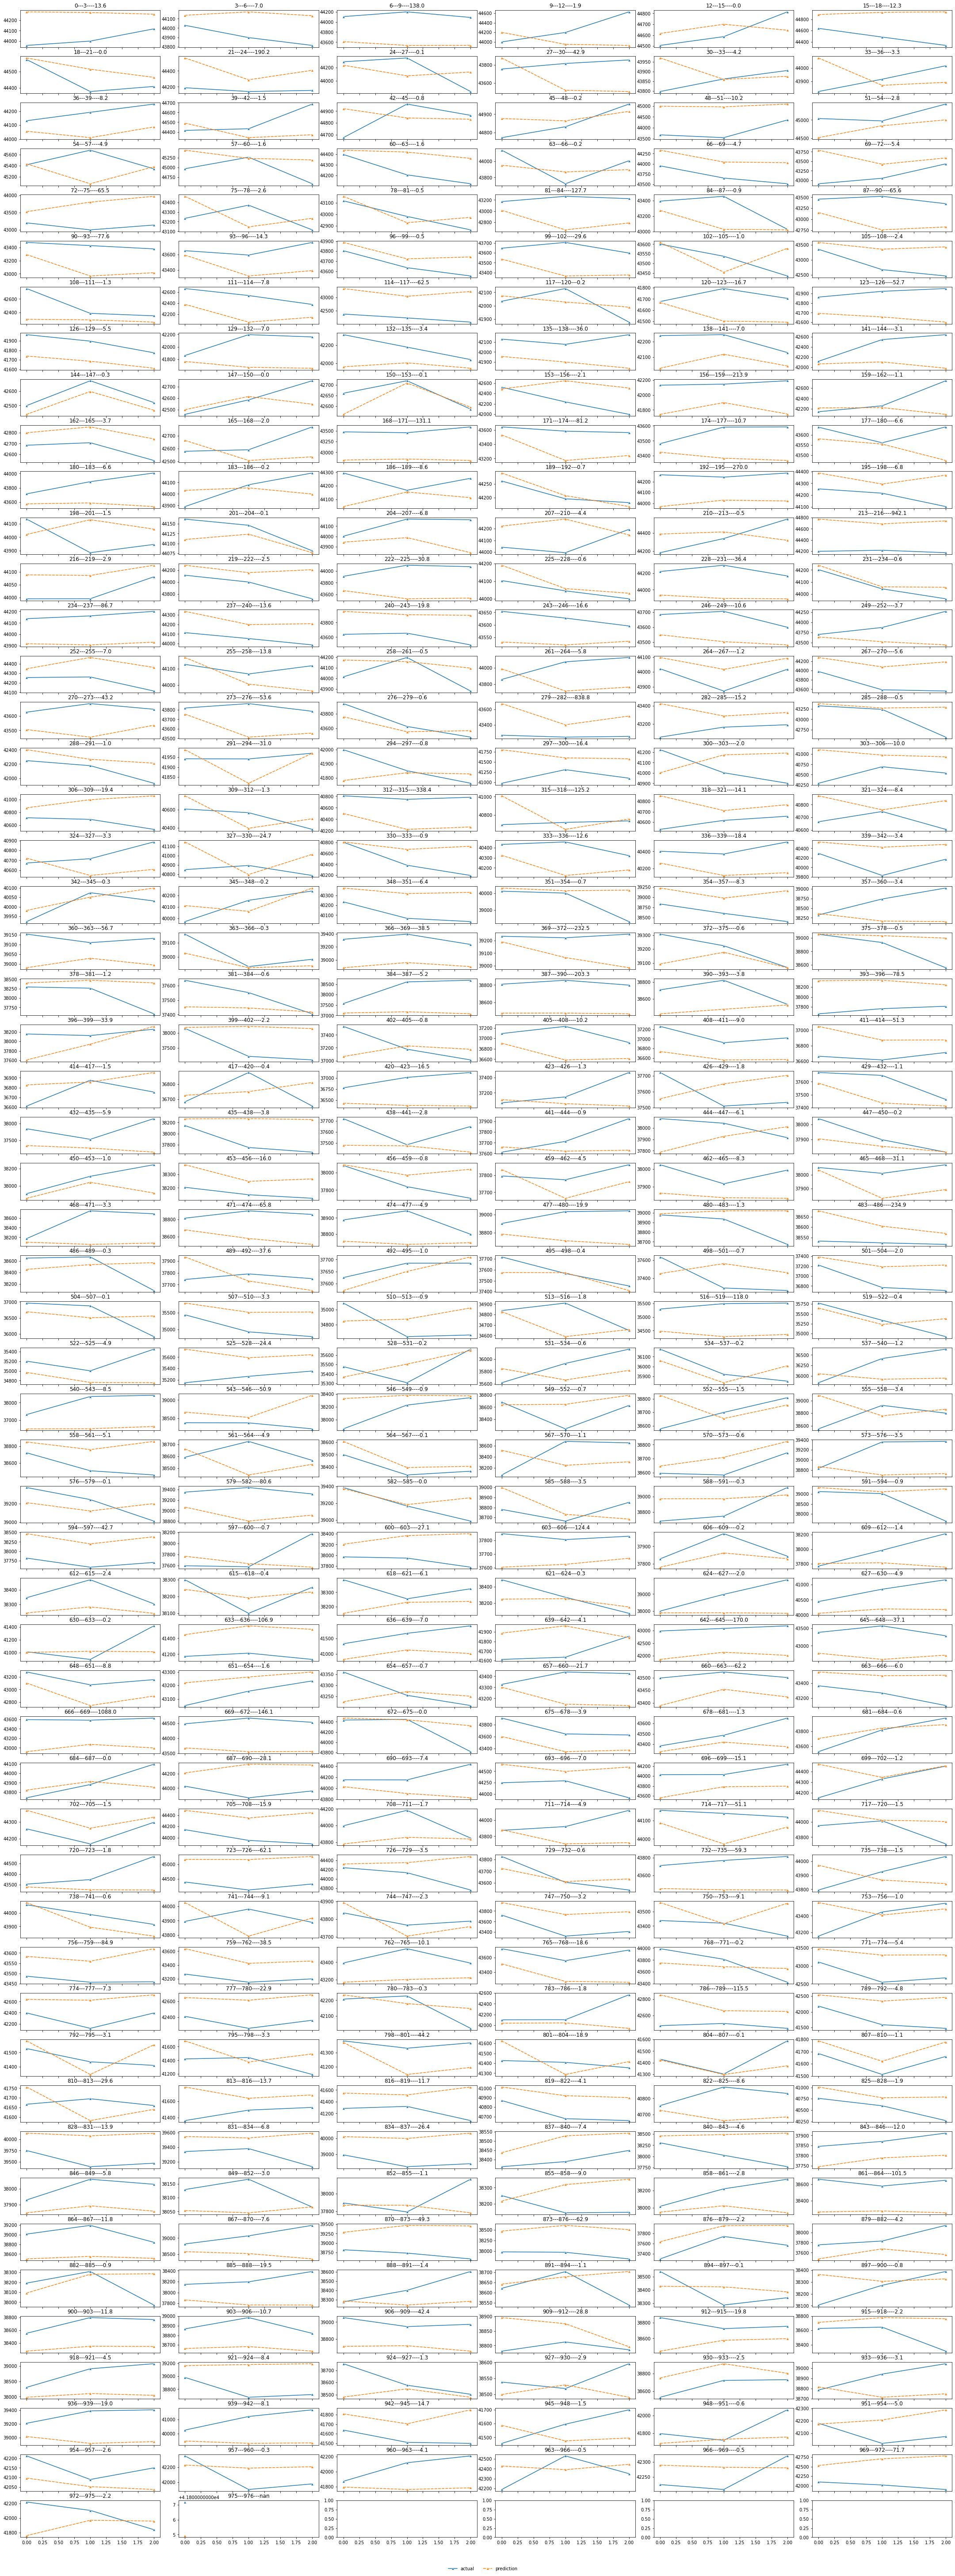

In [10]:
aOutputFeatures = [sOutputSymbol +':close']

iNrOfCols = 6
iNrOfRows = int(((len(dfActualClose)/iNrOfCols)/iForwardTimeWindow) + 1)
oFig, aAxises = plt.subplots(iNrOfRows, iNrOfCols, figsize=(30,80), sharex = True)
oFig.tight_layout()
i = 0
for iSampleNr in range(0, len(dfActualClose), iForwardTimeWindow):
    iFrom = iSampleNr
    iTo = iFrom + iForwardTimeWindow

    if iTo >= len(dfActualClose):
        iTo = len(dfActualClose) 
    
    dfStepComparision = dfActualClose.iloc[iFrom:iTo].loc[:, (slice(None), slice(aOutputFeatures[0]))].loc[:, '0']
    
    dfStepComparision.columns = ["Actual"]

    dfStepComparision["Prediction"] = dfPredictionClose.iloc[iFrom].iloc[0:iTo-iFrom].loc[:, aOutputFeatures].values
    
    
    sTitleName = str(iFrom) + "---" + str(iTo) + "---" + str(round(r2_score(dfStepComparision["Actual"], dfStepComparision["Prediction"]),1))
    
    iSampleGraphRow =  int(i/iNrOfCols)
    iSampleGraphCol = int(i%iNrOfCols)
    
    dfStepComparision.reset_index(inplace = True)
    sns.lineplot(ax =aAxises[iSampleGraphRow,iSampleGraphCol] , data = dfStepComparision, legend = False,  marker = '^').set_title(sTitleName)
    
    i = i + 1

oFig.legend(aAxises[0][0].lines, ['actual', 'prediction'], frameon=False, loc='lower center', ncol=2,  bbox_to_anchor=(0.5,-0.01))  
oFig.get_figure().savefig(sModelName + '\closing price multi step.png')